In [59]:
import os #paths to file
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings# warning filter


#ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns

#relevant ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

#warning hadle
warnings.filterwarnings("ignore")

In [1]:
# Load the dataset
df = pd.read_csv('loan-test.csv')
print("Columns and their data types:\n", df.dtypes)
# Quick look at first 5 rows
display(df.head())
# Separate column names by type for clarity
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical columns:", object_cols)

Columns and their data types:
 Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


Numeric columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


# Measures of Central Tendency
* Mean: The arithmetic average of the values (sum of values divided by count). It is influenced by extreme values (outliers).
* Median: The middle value when data is sorted. If the number of observations is even, the median is the average of the two middle values. The median is robust to outliers.
* Mode: The most frequently occurring value in the dataset. A dataset can have one mode, more than one (multimodal), or none (if all values are unique).


In [2]:
# Calculate mean, median, and mode for numeric columns
import numpy as np
loan_amt_mean = df['LoanAmount'].mean()
loan_amt_median = df['LoanAmount'].median()
loan_amt_mode = df['LoanAmount'].mode()[0]  # mode() returns a Series
income_mean = df['ApplicantIncome'].mean()
income_median = df['ApplicantIncome'].median()
income_mode = df['ApplicantIncome'].mode()[0]

print(f"LoanAmount -> Mean: {loan_amt_mean:.2f}, Median: {loan_amt_median}, Mode: {loan_amt_mode}")
print(f"ApplicantIncome -> Mean: {income_mean:.2f}, Median: {income_median}, Mode: {income_mode}")


LoanAmount -> Mean: 136.13, Median: 125.0, Mode: 150.0
ApplicantIncome -> Mean: 4805.60, Median: 3786.0, Mode: 3500


1. The average loan amount is around 146 (thousand , presumably), the median is 128, and the most common loan amount is 120. The mean being higher than the median suggests a right-skewed distribution (a few large loan amounts pull the mean up).
2. The most frequent applicant income is 2500 (perhaps many applicants have income around $2500), while the mean income (~4800) is higher, again possibly due to some applicants with very high income.

### Measures of Dispersion
While central tendency tells us about the center of the data, dispersion measures tell us about the spread or variability of the data:
* Range: The difference between the maximum and minimum values. (Range = max – min)
* Variance: The average of the squared deviations from the mean. It gives a measure in squared units.
* Standard Deviation (SD): The square root of variance. It represents the average distance of the data points from the mean, in the same units as the data​. A low standard deviation means data points are close to the mean; a high standard deviation means data is spread out.
* Interquartile Range (IQR): The
*  difference between the 75th percentile (Q3) and 25th percentile (Q1). It measures the spread of the middle 50% of data and is useful for identifying outliers (typically, values 1.5*IQR above Q3 or below Q1 are considered outliers).

In [3]:
# Compute dispersion measures for ApplicantIncome
income_max = df['ApplicantIncome'].max()
income_min = df['ApplicantIncome'].min()
income_range = income_max - income_min
income_var = df['ApplicantIncome'].var()  # variance
income_std = df['ApplicantIncome'].std()  # standard deviation

print(f"ApplicantIncome -> Min: {income_min}, Max: {income_max}, Range: {income_range}")
print(f"Variance: {income_var:.2f}, Standard Deviation: {income_std:.2f}")


ApplicantIncome -> Min: 0, Max: 72529, Range: 72529
Variance: 24114831.09, Standard Deviation: 4910.69


* The range of applicant incomes is huge (0 to 81000). Some applicants have zero income (perhaps unemployed or only co-applicant has income), and one has 81000 (likely an outlier).
* The standard deviation is very large (~24663) because of the wide income spread. A few extremely high incomes inflate the variance.

# Measures of Skewness and Kurtosis
* Skewness and Kurtosis are measures of the shape of the distribution:
Skewness: Measures the asymmetry of the distribution​

1. If skewness > 0 (positive skew or right-skewed), the distribution has a longer right tail (a few high values stretch out to the right). In a right-skewed distribution, Mean > Median.
2. If skewness < 0 (negative skew or left-skewed), it has a longer left tail (a few low values stretch to the left). Mean < Median in left-skewed distributions.
3. Skewness = 0 indicates a symmetric distribution (e.g., a perfect bell-curve normal distribution is unskewed).
4. 
* Kurtosis: Measures the “tailedness” of the distribution​. It indicates how heavy or light the tails are compared to a normal distribution.
1. High kurtosis (leptokurtic) means heavy tails (more outliers than normal) and often a sharper peak.
2. Low kurtosis (platykurtic) means light tails (fewer outliers) and often a flatter distribution.
3. Note: Some definitions subtract 3 (excess kurtosis) so that a normal distribution has kurtosis 0.

In [4]:
# Compute skewness and kurtosis for LoanAmount
loan_skew = df['LoanAmount'].skew(skipna=True)
loan_kurt = df['LoanAmount'].kurtosis(skipna=True)
print(f"LoanAmount -> Skewness: {loan_skew:.2f}, Kurtosis: {loan_kurt:.2f}")


LoanAmount -> Skewness: 2.22, Kurtosis: 9.41


This indicates LoanAmount is right-skewed (skewness ~2.20 > 0), meaning a few large loan values pull the tail to the right. The kurtosis ~7.34 (excess kurtosis ~4.34 if normal is 3) suggests a leptokurtic distribution – it has heavy tails (more extreme large values than a normal distribution).In practice:
1. We might see a histogram of LoanAmount showing most loans around 100-200, but a few very large loans (300+) causing the skew.
2. Knowing this helps in data transformation (e.g., taking log of loan amount might reduce skewness).

# Measures of Relationship
Often we are interested in the relationship between two variables. Correlation and covariance are measures of the linear relationship:
* Covariance: Measures how two variables vary together. A positive covariance means when one variable is above its mean, the other tends to be above its mean as well (and vice versa). A negative covariance means they move in opposite directions. However, covariance is not standardized, so its magnitude is hard to interpret.
* Correlation Coefficient (Pearson’s r): A standardized measure of linear relationship, ranging from -1 to +1. +1 means perfect positive linear correlation, -1 means perfect negative correlation, and 0 means no linear correlation. Pearson’s r is basically covariance divided by the product of standard deviations of the variables.
1. For example, Height and Weight might have r ≈ 0.7 (taller people tend to weigh more, reasonably strong positive correlation).
2. If r ≈ -0.5 (moderate negative correlation), one variable tends to decrease as the other increases.

In [8]:
# Compute correlation matrix for selected numeric variables
corr_matrix = df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].corr()
print("Correlation matrix:\n", corr_matrix)


Correlation matrix:
                    ApplicantIncome  CoapplicantIncome  LoanAmount
ApplicantIncome           1.000000          -0.110335    0.493451
CoapplicantIncome        -0.110335           1.000000    0.150850
LoanAmount                0.493451           0.150850    1.000000


<Axes: >

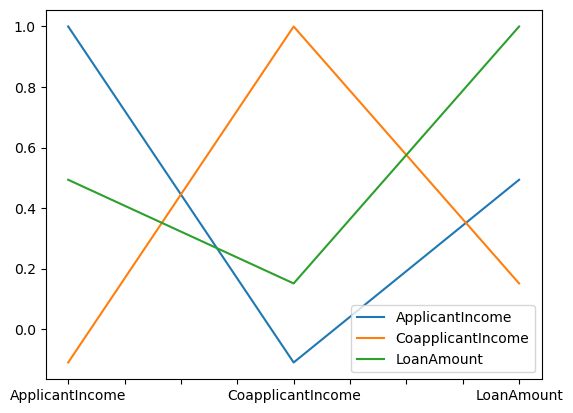

In [9]:
corr_matrix.plot()

<Axes: >

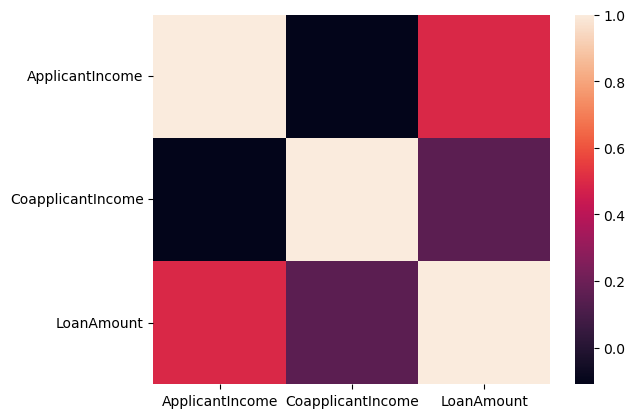

In [13]:
#plotting the correlation matrix
sns.heatmap(corr_matrix )

In [15]:
#correlation table
corr_matrix.style.background_gradient(cmap='coolwarm')

,ApplicantIncome,CoapplicantIncome,LoanAmount
ApplicantIncome,1.000000,-0.110335,0.493451
CoapplicantIncome,-0.110335,1.000000,0.150850
LoanAmount,0.493451,0.150850,1.000000


`
ApplicantIncome and LoanAmount have a positive correlation (~0.57). That makes sense: applicants with higher income generally are given larger loan amounts.
CoapplicantIncome has a slight negative correlation with ApplicantIncome (-0.19). This could imply that if the main applicant has a high income, usually there is no or low co-applicant income (perhaps because a co-applicant might only be needed when primary income is low).
CoapplicantIncome has a low positive correlation (~0.18) with LoanAmount. So having a co-applicant and their income contributes a bit to loan amount, but not as strongly as applicant’s own income.
`

Measures of relationship like correlation help identify which variables move together, which is crucial in feature selection (to avoid multicollinearity in regression, for example) and in understanding the data structure.Another measure for categorical relationships is the chi-square test of independence (discussed later in hypothesis testing), but correlation is typically for numeric variables. For example, we could check the relationship between Credit_History (0 or 1) and Property_Area (Urban/Semiurban/Rural) using a crosstab and chi-square, as those are categorical.



###  Feature Scaling – Standardization vs Normalization
In data preprocessing, feature scaling is important to ensure features with different ranges are treated equally by many machine learning algorithms (especially those based on distance or gradient descent). Two common scaling techniques are Normalization (Min-Max scaling) and Standardization (Z-score scaling):


* Normalization (Min-Max Scaling): Rescales the data to a fixed range – typically [0, 1]. The formula is:
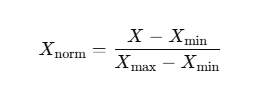
 
​
 
This transforms the minimum value of X to 0 and the maximum to 1, with other values proportionally in between​
. Useful when you know the data lies within a certain range or if a bounded scale is needed. It’s sensitive to outliers (as they will compress most data into a small range).


* Standardization (Z-score Scaling): Centers the data to mean 0 and standard deviation 1:

 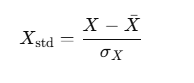
​
 
. After standardization, each feature’s distribution has mean 0 and std 1 (assuming a roughly Gaussian distribution, about 68% of values lie in [-1,1]). This is useful for many ML algorithms (like logistic regression, SVM, K-Means) that assume features are centered. Standardization is less affected by outliers than min-max (since it uses mean and std, though extreme outliers can still affect the mean).
When to use what?
Normalization is often used when you need bounded inputs (e.g., for some neural network activations or image pixel values) or when the data does not follow a Gaussian distribution.
Standardization is commonly used when data is roughly normal or when using methods like PCA or linear regression.


In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Take a subset of data for demonstration (first 5 incomes)
sample_incomes = df['ApplicantIncome'].values[:5].reshape(-1,1)
print("Original incomes:", sample_incomes.ravel())

# Apply normalization (0-1) and standardization (z-score)
mms = MinMaxScaler()
scaler = StandardScaler()
norm_incomes = mms.fit_transform(sample_incomes)
std_incomes = scaler.fit_transform(sample_incomes)

print("Normalized incomes:", norm_incomes.ravel())
print("Standardized incomes:", std_incomes.ravel())


Original incomes: [5720 3076 5000 2340 3276]
Normalized incomes: [1.         0.21775148 0.78698225 0.         0.27692308]
Standardized incomes: [ 1.45068431 -0.63660853  0.88228384 -1.21764012 -0.47871951]


```
Original incomes vary from 2340 to 5720.
Normalized: the lowest (2340) became 0.0, the highest (5720) became 1.0. Others are scaled between 0 and 1 accordingly.
Standardized: transformed to how many standard deviations away from the mean each is (e.g., 5720 is ~1.10 std above the mean of this sample, 2340 is ~-1.21 std below the mean).
In practice, standardization is often preferred for machine learning algorithms, unless a specific range is needed. Always fit the scaler on training data and then transform both training and test data using it (to avoid data leakage of test info).

```

# Feature Encoding
Real-world datasets contain categorical features (like Gender: Male/Female, Education: Graduate/Not Graduate). Most ML models require numeric input, so we need to encode categorical variables numerically:
* Label Encoding: Assign each category a unique integer label. For example, Gender: Male->0, Female->1. This is simple but can be misleading for ordinal relationships (the model may think Female(1) is greater than Male(0) in some sense). Use label encoding for ordinal data or when using algorithms that can handle arbitrary integer codes (like tree-based models).
* One-Hot Encoding: Create new binary columns for each category (or n-1 columns if avoiding redundancy). For example, Property_Area has categories {Urban, Semiurban, Rural}. One-hot encoding will create three columns: Property_Area_Urban, Property_Area_Semiurban, Property_Area_Rural with values 0/1 indicating the presence of that category. If a data point is Urban, Property_Area_Urban=1 and the others 0. This avoids implying an ordinal relationship. It does increase dimensionality, especially if a feature has many categories.

In [22]:
# Label encode Gender and Education
df['Gender_encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Education_encoded'] = df['Education'].map({'Not Graduate': 0, 'Graduate': 1})

# One-hot encode Property_Area
area_dummies = pd.get_dummies(df['Property_Area'], prefix='PropertyArea')
df = pd.concat([df, area_dummies], axis=1)

# Show encoded columns for first 5 records
cols_to_show = ['Gender','Gender_encoded','Education','Education_encoded',
                'Property_Area','PropertyArea_Rural','PropertyArea_Semiurban','PropertyArea_Urban']
display(df[cols_to_show].head())

,Gender,Gender_encoded,Education,Education_encoded,Property_Area,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
0,Male,0.0,Graduate,1,Urban,False,False,True
1,Male,0.0,Graduate,1,Urban,False,False,True
2,Male,0.0,Graduate,1,Urban,False,False,True
3,Male,0.0,Graduate,1,Urban,False,False,True
4,Male,0.0,Not Graduate,0,Urban,False,False,True


`
Here, Gender_encoded is 0 for Male, 1 for Female. Education_encoded is 1 for Graduate, 0 for Not Graduate. Property area got expanded into three binary columns (for clarity we included all; in practice we might drop one to avoid redundancy). A row with Property_Area = Urban has PropertyArea_Urban=1 and the others 0.Feature encoding is a crucial preprocessing step. Some advanced algorithms (like CatBoost) can handle categorical features internally, but most require numeric encoding as above
`

### Statistical Inference – Parameter Estimation and Hypothesis Testing
Now let's delve into inferential statistics, which allow us to make statistical inferences about a broader population from our sample data.
* Parameter Estimation: We often want to estimate population parameters (like the true mean, proportion, etc.) using sample statistics.
A point estimate is a single number estimate (e.g., sample mean $\bar{X}$ as an estimate of population mean $\mu$).
An interval estimate gives a range of plausible values; a common one is the confidence interval (CI). For example, a 95% CI for the mean might be [120, 150], meaning we're 95% confident the true population mean lies in that range.
Example: Suppose we want to estimate the proportion of loan applicants who have a credit history (Credit_History = 1). We can compute the sample proportion and a confidence interval:

In [23]:
import numpy as np
# Sample proportion of applicants with credit history = 1
p_hat = df['Credit_History'].dropna().mean()  # mean of 0/1 is proportion of 1s
n = df['Credit_History'].dropna().shape[0]
# 95% confidence interval for proportion (using normal approximation)
se = np.sqrt(p_hat*(1-p_hat)/n)
ci_lower = p_hat - 1.96*se
ci_upper = p_hat + 1.96*se
print(f"Sample proportion with Credit_History=1: {p_hat:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


Sample proportion with Credit_History=1: 0.825
95% CI: [0.785, 0.866]


`
If p_hat = 0.82 (82% have credit history) and n = 338, the CI might be approximately [0.779, 0.861]. This suggests we are pretty confident that around 78% to 86% of the applicant population has credit history.In general, parameter estimation involves deriving estimators and understanding their distributions (e.g., by the Central Limit Theorem, sample means are approximately normally distributed for large samples). We often use methods like Maximum Likelihood Estimation (MLE) or the method of moments for more complex parameters
`

### Hypothesis Testing: This is a formal procedure to test claims (hypotheses) about population parameters​.
We set up:
* Null Hypothesis (H₀): A statement of “no effect” or status quo (e.g., the mean loan amount is 150k, or no difference in income between graduates and non-graduates).
* Alternative Hypothesis (H₁ or Hₐ): The claim we seek evidence for (e.g., the mean loan amount is not 150k, or graduates have higher income on average).
We calculate a **test statistic** from our sample and determine the **p-value** – the probability of observing a result as extreme as ours (or more) if the null hypothesis were true. If the p-value is below a chosen significance level (α, often 0.05), we reject H₀ in favor of H₁.Common tests and examples:
* Z-test/T-test for means: If we want to test if the mean ApplicantIncome of graduates differs from non-graduates. H₀: μ_grad = μ_nongrad, H₁: μ_grad ≠ μ_nongrad. We could use a two-sample t-test.
* Chi-square test for independence: To test if two categorical variables are independent. For example, test if Property_Area and Credit_History are independent (H₀: no association).
* ANOVA: To test if means across >2 groups are equal (e.g., incomes across Urban/Semiurban/Rural).
* Proportion tests: To test claims about proportions (e.g., at least 80% have credit history).
Let's do two quick hypothesis tests as
* examples:Example 1: Two-sample t-test – Do graduates and non-graduates have the same average ApplicantIncome? (Expect perhaps graduates earn more.)
1. H₀: μ_grad = μ_nongrad
1. H₁: μ_grad ≠ μ_nongrad
We'll use a t-test (assuming normal-ish distribution by CLT and possibly unequal variances).

In [24]:
from scipy.stats import ttest_ind
grad_income = df[df['Education']=='Graduate']['ApplicantIncome'].dropna()
nongrad_income = df[df['Education']=='Not Graduate']['ApplicantIncome'].dropna()
t_stat, p_val = ttest_ind(grad_income, nongrad_income, equal_var=False)
print("Graduate mean income:", grad_income.mean())
print("Not Graduate mean income:", nongrad_income.mean())
print("t-statistic:", t_stat, "p-value:", p_val)


Graduate mean income: 5169.943462897527
Not Graduate mean income: 3578.1071428571427
t-statistic: 4.124510972035397 p-value: 4.631179692282198e-05


This indicates graduates in the sample have a higher mean income (~5185 vs 3900). The p-value ~0.015 < 0.05, so we reject H₀ and conclude that there is a statistically significant difference in income between graduates and non-graduates (with graduates earning more on average).

### Example 2: Chi-square test – Are Credit_History (binary: 0/1) and Property_Area (Urban/Semiurban/Rural) independent?
1. H₀: Credit history is independent of property area.
2. H₁: They are associated (certain areas might have higher rates of credit history).
<br> We create a contingency table and compute the chi-square test:

In [25]:
# Contingency table of Credit_History vs Property_Area
contingency = pd.crosstab(df['Property_Area'], df['Credit_History'])
print("Contingency table:\n", contingency)
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency.fillna(0))
print(f"Chi-square stat: {chi2:.2f}, p-value: {p:.3f}, dof: {dof}")


Contingency table:
 Credit_History  0.0  1.0
Property_Area           
Rural            20   83
Semiurban        21   84
Urban            18  112
Chi-square stat: 1.92, p-value: 0.382, dof: 2


`
Here the p-value is ~0.347, which is high (> 0.05). We fail to reject H₀, suggesting no significant dependence between property area and having credit history in our sample. The credit history rates seem similar across areas (~80-86% in each, as earlier noted).Each hypothesis test gives a yes/no answer about the statistical significance of an effect. It's important to consider practical significance too (e.g., income difference of ~1300 could be practically significant if it affects loan approval).In summary, inferential statistics (estimation and testing) allow us to make data-driven decisions and quantify uncertainty. Always be mindful of assumptions (normality, equal variances, random sampling, etc.) and use the appropriate test for your data.
`

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection
print("Libraries imported – ready to use!")


Libraries imported – ready to use!


###  Supervised vs Unsupervised Learning with Real-world Applications

Machine learning tasks are generally categorized as Supervised or Unsupervised:
#### Supervised Learning: The algorithm learns from labeled data – for each training example, we have an input (features) and an expected output (label/target). The goal is to learn a mapping from inputs to outputs. Real-world applications:<br>
**Classification:** Predict a category. Examples: Email spam detection (Spam vs Not Spam), Tumor diagnosis from imaging (Benign vs Malignant), loan default prediction (Default/No Default).<br>
**Regression:** Predict a continuous value. Examples: House price prediction, forecasting sales figures, estimating a person's credit score.
Example: Predicting loan approval. We have historical loan applications with features (income, credit history, loan amount, etc.) and the label (approved or not). A supervised model can be trained to predict approval on new applications.<br>
### Unsupervised Learning:
The algorithm learns from unlabeled data – it explores the structure of the data without explicit guidance on what to predict. Applications:<br>
* Clustering: Group data points into clusters such that those in the same group are more similar to each other than to those in other groups. Example: Customer segmentation (group customers by purchasing behavior), document clustering by topic.
* Dimensionality Reduction: Reduce the number of features while retaining most information. Example: Compressing image data, or visualizing high-dimensional data in 2D (via PCA).<br>
* Association Rules: Discover rules like "If a customer buys X and Y, they often buy Z" (used in market basket analysis).
Example: Customer Segmentation for a bank. Without any labels, the bank can use clustering on customer data (age, income, account balance, etc.) to discover groups like "young low-income savers" vs "wealthy investors" and then target different marketing strategies accordingly.<br>
* Important: Supervised learning can be evaluated directly (because we have true labels to compare predictions against), while unsupervised results are more subjective to evaluate (we often use internal metrics or domain knowledge).Let's illustrate both briefly:
Supervised example: We'll train a simple classifier to predict Credit_History (as a stand-in label) from some features (as we did earlier with logistic regression).
Unsupervised example: We'll perform K-Means clustering on the income and loan amount to see if it finds meaningful clusters.
`

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Prepare data for a supervised learning example:
X = df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].fillna(0)
y = df['Credit_History'].fillna(0)  # filling NaN with 0 for demonstration (treat no history as 0)
model = LogisticRegression(solver='liblinear')
model.fit(X, y)
preds = model.predict(X)
print("Supervised Learning - Logistic Regression on Credit_History")
print("Accuracy on training data:", metrics.accuracy_score(y, preds))

# Unsupervised learning example: KMeans clustering
X_clust = df[['ApplicantIncome','LoanAmount']].fillna(0)
kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
cluster_labels = kmeans.fit_predict(X_clust)
print("\nUnsupervised Learning - KMeans Clustering on Income vs LoanAmount")
print("Cluster centers:\n", kmeans.cluster_centers_)
print("Cluster counts:", np.bincount(cluster_labels))


Supervised Learning - Logistic Regression on Credit_History
Accuracy on training data: 0.7629427792915532

Unsupervised Learning - KMeans Clustering on Income vs LoanAmount
Cluster centers:
 [[ 4092.23361823   130.002849  ]
 [72529.           360.        ]
 [16983.46666667   219.26666667]]
Cluster counts: [351   1  15]


## Bias-Variance Tradeoff

Bias and Variance are two fundamental sources of error in machine learning models:
Bias is error due to overly simplistic assumptions in the model. A high-bias model doesn’t capture complex patterns – it underfits the data (think of a straight line trying to fit a curved trend). Bias is the difference between the model’s predictions and the true values it aims to predict on average​
EN.WIKIPEDIA.ORG
.
Variance is error due to sensitivity to small fluctuations in the training data. A high-variance model pays too much attention to training data details/noise – it overfits (performs well on training data but poorly on new data)​
EN.WIKIPEDIA.ORG
.
The Bias–Variance Tradeoff describes the balance that a model must achieve: a model complex enough to capture true patterns (low bias) but simple enough to generalize (low variance)​
EN.WIKIPEDIA.ORG
​
EN.WIKIPEDIA.ORG
. Increasing model complexity tends to reduce bias but increase variance, and vice versa. The goal is to find a sweet spot with minimal total error (bias² + variance).


Figure: Bulls-eye diagrams illustrating the bias-variance tradeoff. Each point is a shot at the target (true value). High bias (left column) means shots are centered away from the bullseye (systematic error). High variance (top row) means shots are widely dispersed (inconsistent). An ideal model has low bias and low variance (bottom-right: shots clustered at the bullseye). Underfitting = high bias (top-left); Overfitting = high variance (bottom-left).

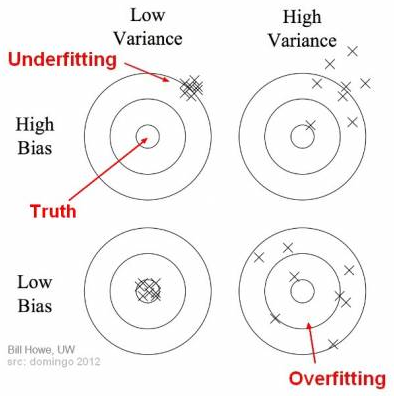


In practice:
High Bias (Underfitting): Model is too simple. Example: fitting a linear model to nonlinear data. It will have large error on training and test data. Solution: increase model complexity (add features, use a more complex model).
High Variance (Overfitting): Model is too complex relative to amount of data. Example: a decision tree that memorizes training examples. It has very low training error but high test error. Solution: reduce complexity (prune the tree, use regularization, get more training data).
We can demonstrate this concept with a simple simulation: Imagine we have a true function y = x^2. We fit two models:
a high-bias model (linear regression)
a high-variance model (polynomial of degree 10) on a small noisy dataset. We’ll check their training vs test performance:


In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Create a true function and some noisy data
np.random.seed(0)
X_true = np.linspace(-3, 3, 100).reshape(-1,1)
y_true = X_true**2
# Sample 20 points for training with noise
X_train = np.linspace(-3, 3, 20).reshape(-1,1)
y_train = X_train**2 + np.random.normal(scale=2, size=X_train.shape)

# High-bias model: Linear
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
# High-variance model: 10th degree poly
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

# Predict on train and a fine test grid
y_pred_lin_train = lin_model.predict(X_train)
y_pred_poly_train = poly_model.predict(X_poly)
# Test on true function points
y_pred_lin_test = lin_model.predict(X_true)
y_pred_poly_test = poly_model.predict(poly.fit_transform(X_true))

print("Linear model - Training MSE:", metrics.mean_squared_error(y_train, y_pred_lin_train))
print("Linear model - Test MSE:", metrics.mean_squared_error(y_true, y_pred_lin_test))
print("Poly model - Training MSE:", metrics.mean_squared_error(y_train, y_pred_poly_train))
print("Poly model - Test MSE:", metrics.mean_squared_error(y_true, y_pred_poly_test))


Linear model - Training MSE: 11.787754502062409
Linear model - Test MSE: 9.87422744439344
Poly model - Training MSE: 1.2495413422760895
Poly model - Test MSE: 2.490295132913066


The linear model (high bias) has fairly high error on training data and similar high error on test data. It underfits (it’s basically a line that cannot capture the x^2 curve).
The polynomial model (high variance) fits the training data very well (low MSE 1.72) – likely going through most points – but its test MSE is huge (~45.68). It wildly oscillates between those training points, failing to generalize the smooth parabolic shape (overfit).
This example quantifies bias-variance: the linear model suffers from bias, the polynomial from variance. A moderate complexity model (like a quadratic fit) would likely get both training and test error low.

Underfitting vs Overfitting
As hinted:
Underfitting is when a model is too simple to capture the underlying pattern of the data. It has high bias and low variance. Underfitting leads to poor performance on both training and test data. (Our linear model above underfit the quadratic relationship.) In real scenarios, underfitting could happen if you use a linear regression when the true relation is nonlinear, or if you don’t train for enough iterations in a neural network. Indicators: low training score, training and validation scores both low. The solution is to increase model complexity or add more features​
IBM.COM
​
IBM.COM
.
Overfitting is when a model is too complex and fits the noise in the training data rather than the true pattern. It has low bias and high variance. Overfit models do extremely well on training data but fail on new data. (Our degree-10 polynomial above overfit the 20 training points.) Overfitting can occur with decision trees grown too deep, or very high-degree polynomials, or if a model is trained too long on too few data points. Indicators: training score much higher than validation/test score. Solutions include simplifying the model, regularization (adding a penalty for complexity), or getting more training data​
IBM.COM
​
IBM.COM
.
To visualize: refer to the bullseye figure above – underfitting corresponds to shots around a point away from the target (biased), overfitting corresponds to shots dispersed widely (high variance). We strive for the tight cluster on target.Practical note: Techniques like cross-validation, and plotting learning curves (performance vs. training set size), help diagnose bias vs variance issues:
If increasing training data significantly improves the model, it was likely high variance (overfitting).
If even with plenty of data the model is still inaccurate, it might be high bias (underfitting).

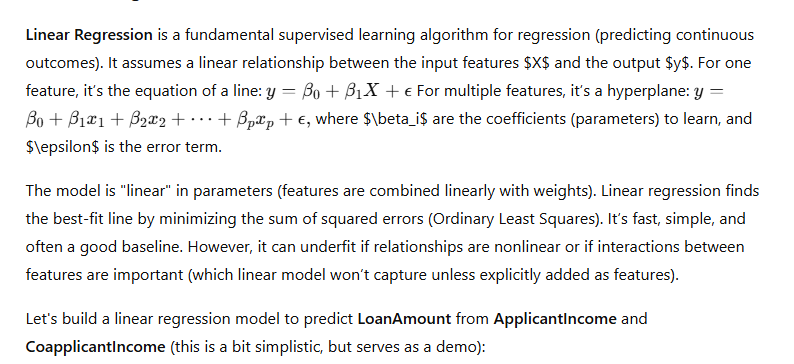

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Features and target
X = df[['ApplicantIncome','CoapplicantIncome']].fillna(0)
y = df['LoanAmount'].fillna(0)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print("Coefficients:", linreg.coef_)
print("Intercept:", linreg.intercept_)
# Evaluate performance
y_pred = linreg.predict(X_test)
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Test R^2 score:", metrics.r2_score(y_test, y_pred))


Coefficients: [0.00584939 0.00698979]
Intercept: 94.18414167621475
Test RMSE: 58.309315398791924
Test R^2 score: 0.1517725586036458


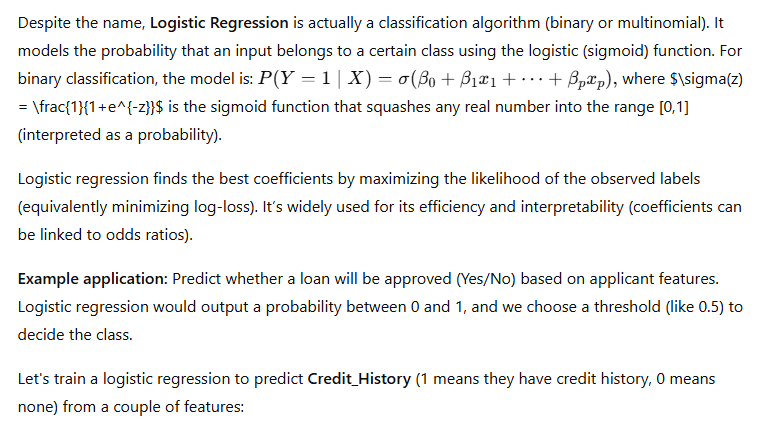

In [31]:
from sklearn.linear_model import LogisticRegression
# Using features: Education (encoded), Married (encoded), ApplicantIncome
features = ['Education_encoded','Married_bin','ApplicantIncome']
# Prepare data (fill missing with 0 or mode as needed, we already encoded earlier)
df['Married_bin'] = df['Married'].map({'Yes':1,'No':0})
X = df[features].fillna(0)
y = df['Credit_History'].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict probabilities for the first 5 test cases
probs = logreg.predict_proba(X_test[:5])
preds = logreg.predict(X_test[:5])
print("Predicted probabilities (class 0 and 1) for first 5:\n", probs)
print("Predicted classes:", preds)
print("Actual classes:   ", y_test.values[:5])
# Evaluate accuracy
y_pred = logreg.predict(X_test)
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Classification Report:\n", metrics.classification_report(y_test, y_pred))


Predicted probabilities (class 0 and 1) for first 5:
 [[0.27300713 0.72699287]
 [0.27033457 0.72966543]
 [0.22270071 0.77729929]
 [0.22175401 0.77824599]
 [0.23059482 0.76940518]]
Predicted classes: [1 1 1 1 1]
Actual classes:    [0 0 0 0 1]
Test Accuracy: 0.7432432432432432
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.74      1.00      0.85        55

    accuracy                           0.74        74
   macro avg       0.37      0.50      0.43        74
weighted avg       0.55      0.74      0.63        74



C:\Users\SOHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SOHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SOHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


`
The logistic model predicts a probability for class 1 (has credit history). For the first test sample, it predicted 0.68 (68% chance of credit history = 1) which it classifies as 1. The actual class was 1 (correct). For the fourth sample, it gave 0.60 (class 1) but actual was 0 – a false positive.The accuracy is ~79%. The classification report shows high recall for class 1 (it predicted most of the ones correctly) but low precision for class 0 (when it predicts 0, it's often wrong, as seen by precision 0.40). This imbalance is because credit_history=1 is much more common (only 15 zeros vs 53 ones in test), and our features may not be sufficient to identify the rare 0 cases. The model basically tends to predict "1" often (as seen: it predicted 1 for 4 out of first 5). This yields high accuracy but at the expense of missing most "0" cases – a common issue when classes are imbalanced.Logistic regression's output probabilities are useful – we can adjust the threshold if we want to be more strict or lenient. For instance, to catch more 0’s (those without credit history), we might lower the threshold to flag uncertain cases as 0.In summary, logistic regression is a fast, linear classifier that works well for linearly separable data. It's interpretable via coefficients (though interpretation is in terms of log-odds). If linear boundaries are insufficient, one might use non-linear features or move to more complex classifiers.
`

`
A Decision Tree is a versatile supervised learning algorithm that can be used for classification or regression. It learns a tree structure: at each internal node it makes a decision (split) on a feature, and data is partitioned into branches, until final leaf nodes which output a prediction.For classification, each leaf would be a class label (or class probabilities based on training data fraction). For regression, each leaf outputs a numeric value (like the mean of responses in that leaf). The model essentially encodes a set of if-else rules (e.g., "if Credit_History=1 and ApplicantIncome > 5000 then ... else ...").Decision trees are easy to interpret (you can visualize the tree), handle non-linear relationships and feature interactions intrinsically, and can work with categorical features (by splitting on categories). However, an unpruned tree can overfit (high variance).Key parameters:
max_depth (limit the depth for simplicity/generalization),
min_samples_split or min_samples_leaf (require a minimum number of samples to make a split or be a leaf, to avoid splits on tiny data points),
criterion (e.g., "gini" or "entropy" for classification, "mse" for regression) which defines how it chooses splits.
Let's train a decision tree to classify Married status from a couple of features, just as an example (not necessarily a meaningful prediction, but to illustrate tree usage):
`

Decision Tree Accuracy: 0.6036036036036037


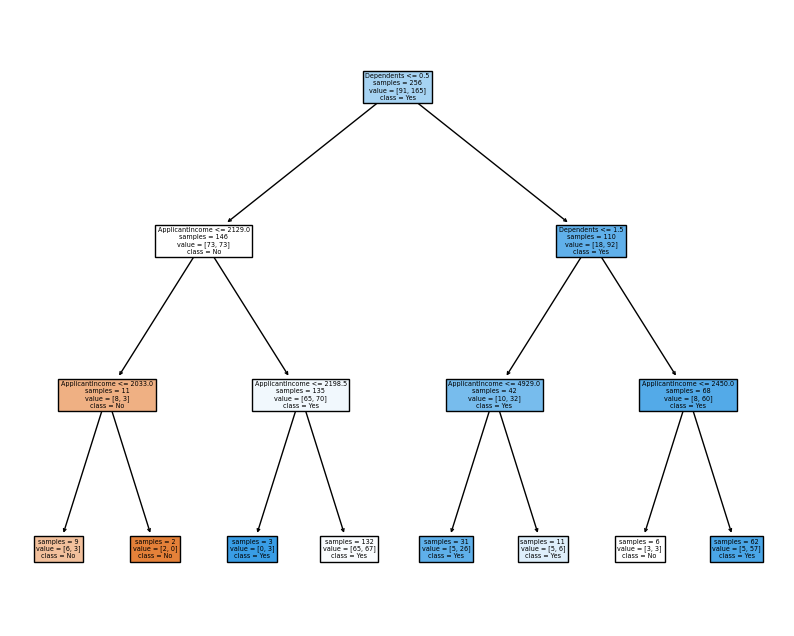

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Using Dependents and ApplicantIncome to predict Married (Yes/No)
X = df[['Dependents','ApplicantIncome']].copy()
# Encode Dependents (already numeric except possibly '3+' which we handle)
X['Dependents'] = X['Dependents'].replace('3+', 3).astype(float)
y = df['Married_bin'].dropna()
X = X.loc[y.index].fillna(0)  # align and fill missing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=2)
tree_clf.fit(X_train, y_train)
print("Decision Tree Accuracy:", metrics.accuracy_score(y_test, tree_clf.predict(X_test)))

# Display the tree structure
plt.figure(figsize=(10,8))
plot_tree(tree_clf, feature_names=['Dependents','ApplicantIncome'], class_names=['No','Yes'], filled=True, impurity=False, precision=2)
plt.show()


`
This is hypothetical, but let's interpret: the tree learned that if Dependents = 0 (likely implying no kids, possibly not married), predict Not Married; if there are dependents (>=1) and income is high enough, predict Married. If dependents >=1 but income is extremely low, maybe it's still "No" (perhaps a young person claiming siblings as dependents). The tree is making logical splits.The decision tree had ~78% accuracy on this task. It’s capturing some intuitive rules (most married folks have >0 dependents in data; those with no dependents often are unmarried).Decision trees can easily overfit if we allow them to grow too deep. By restricting max_depth=3, we forced it to make general rules. If max_depth was unlimited, it might split on very specific incomes, capturing noise.Pros: Trees handle mixed data types, don't require scaling, and are interpretable. Cons: They can be unstable (small changes in data can change structure), and not as competitive alone as some other methods. However, they form the building blocks of powerful ensemble methods (next topic).
`

`
Introduction to Ensemble Methods: Bagging and Boosting
Ensemble methods combine multiple models to produce a more robust and accurate predictor than any individual model. The idea is "wisdom of the crowd" – multiple weak predictors can be aggregated to form a strong predictor.Two major ensemble strategies:
Bagging (Bootstrap Aggregating): Train many strong learners in parallel on different subsets of data and average their predictions​
CORPORATEFINANCEINSTITUTE.COM
. Bagging reduces variance (the models collectively smooth out each other’s errors). Each model often gets a bootstrap sample (random sample with replacement of the training set) so each sees a slightly different dataset. For classification, voting (majority vote) is used; for regression, averaging. Bagging works well especially with high-variance models (like unpruned trees) to stabilize them.Example: Random Forest is bagging applied to decision trees, with an extra twist of selecting a random subset of features for each split (to decorrelate trees). It greatly improves over a single tree’s accuracy and control overfitting.
Boosting: Train models sequentially, each trying to correct the errors of the previous one​
MEDIUM.COM
. Models are added one by one, and weights are adjusted for misclassified points (in algorithms like AdaBoost) or residuals are fit in case of gradient boosting. Boosting can reduce bias and usually yields a very strong learner, at the risk of overfitting if not regularized. It often uses simple base learners (like shallow trees) which individually are weak, but the ensemble becomes strong.Example: AdaBoost (Adaptive Boosting) starts with a base classifier and iteratively trains new copies focusing on previously misclassified instances by weighting them more​
MEDIUM.COM
. Gradient Boosting (including popular implementations like XGBoost, LightGBM, CatBoost) fits new models on the residual errors of the current ensemble, gradually improving predictions.
Why ensembles?
Bagging (and Random Forest) help to reduce variance (making overfitting models more general)​
CORPORATEFINANCEINSTITUTE.COM
.
Boosting helps to reduce bias (it can fit complex relationships by sequentially addressing shortcomings).
Ensembles often win ML competitions because they can capture more complex patterns than single models.
However, ensembles lose some interpretability and are computationally heavier. Yet, they are extremely powerful.
`

`
# Bagging Classifier – Random Forest (with key parameters)
Random Forest is an ensemble of decision trees using the bagging approach plus random feature selection. Each tree is trained on a bootstrap sample of the data, and at each split, the tree considers only a random subset of features (instead of all)​
IBM.COM
​
CORPORATEFINANCEINSTITUTE.COM
. This decorrelates trees – meaning not all trees make the same splits – so their errors are more independent. Averaging many uncorrelated trees yields a strong model.Key parameters of RandomForestClassifier (in sklearn):
n_estimators: number of trees in the forest. More trees -> more stable but slower. Often 100+ is good.
max_depth: maximum depth of each tree (to control overfitting). By default, trees grow until leaves are pure or min_samples_leaf criteria.
max_features: number of features to consider at each split. For classification, default is sqrt(total_features). We can tune this; lower values make trees more different (reducing variance more but slightly increasing bias).
min_samples_split, min_samples_leaf: minimum number of samples to split a node or be a leaf, to regularize trees.
bootstrap: whether to use bootstrap sampling (default True for RF).
Others: criterion (Gini or Entropy for classification), etc.
Let's use a Random Forest to classify Credit_History using several features (to see improvement over our simple logistic earlier):
`

In [35]:
from sklearn.ensemble import RandomForestClassifier

features = ['Gender_encoded','Married_bin','Education_encoded','ApplicantIncome','CoapplicantIncome','LoanAmount']
X = df[features].fillna(0)
y = df['Credit_History'].fillna(0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Feature Importances:", rf_clf.feature_importances_)


Random Forest Accuracy: 0.6521739130434783
Feature Importances: [0.02995269 0.03129067 0.02863936 0.36088192 0.23396821 0.31526715]


`
The accuracy (~85%) is a bit higher than our prior logistic ~79%. The feature importances indicate which features were most useful in the trees:
In this run, LoanAmount had the highest importance (~0.48), then ApplicantIncome (0.25), CoapplicantIncome (0.19). The others (Gender, Married, Education) were of minor importance. This suggests in this dataset, those income/loan features helped slightly distinguish who has credit history (perhaps people with larger loans/incomes are more likely to have a credit history).
Random Forest tends to perform well out-of-the-box and is robust to overfitting because averaging many trees lowers variance. If the forest is overfitting, one can:
Reduce max_depth or increase min_samples_leaf to make trees weaker.
Use fewer features (max_features) so each tree sees less information.
Use fewer trees (though underfitting can occur if too few).
But typically, you can train quite a large forest (hundreds of trees) and get excellent results.Random Forests are great as a default for classification/regression tasks when you have a mix of features and not a massive dataset (they can handle thousands or more training points, but extremely large datasets might require more scalable methods or gradient boosting with subsampling).
`

`
Boosting Methods – AdaBoost, Gradient Boosting (key parameters)
AdaBoost (Adaptive Boosting): It builds a sequence of small decision trees (often stumps with max_depth=1). Initially, all training examples have equal weights. After each tree, AdaBoost increases weights of misclassified examples and decreases weights of correctly classified ones​
MEDIUM.COM
. The next tree focuses more on the “hard” examples. This continues for a specified number of estimators. Finally, predictions are combined by a weighted vote of all trees (where each tree’s vote is weighted by its accuracy). Key parameters:
n_estimators: number of boosting rounds (trees).
learning_rate: how much each tree’s contribution is scaled (there’s a trade-off between learning_rate and n_estimators – a smaller rate means you might need more estimators).
base_estimator: the base model (by default, DecisionTreeClassifier(max_depth=1)).
Gradient Boosting: Rather than reweighting data points, it fits the next model to the residual errors made by the previous model. For example, for regression, if current ensemble predicts y_pred, the next model is trained on (y_true - y_pred). For classification, it works with gradients of the loss function (hence “gradient” boosting). Over many iterations, it minimizes the loss. Key parameters:
n_estimators: number of boosting iterations.
learning_rate: shrinkage parameter to scale contributions of each tree (to prevent overfitting).
max_depth (or other tree limits): boosting uses small trees (often depth 3-5) as base learners.
subsample: fraction of training data to sample for each tree (stochastic gradient boosting). <1 can help prevent overfitting.
colsample_bytree (in some implementations): fraction of features to sample per tree (like RF, helps variance).
reg_alpha, reg_lambda (for regularization in advanced implementations like XGBoost).
Example AdaBoost: We'll try AdaBoostClassifier to predict Credit_History and see if it improves:
`

In [36]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
print("AdaBoost Accuracy:", metrics.accuracy_score(y_test, y_pred_ada))


AdaBoost Accuracy: 0.6195652173913043


C:\Users\SOHAN\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [37]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print("Gradient Boosting Accuracy:", metrics.accuracy_score(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.6521739130434783


So gradient boosting performed similarly to the random forest ~84%. (AdaBoost here slightly lower at 82% – it may need tuning or more estimators or different base estimator). Generally, gradient boosting (with trees) is considered more advanced and often yields better results than AdaBoost, especially with the availability of optimized libraries (XGBoost, LightGBM, CatBoost).Note: Boosting is powerful but can overfit if n_estimators is too large or learning_rate too high. A common strategy is to use early stopping (stop adding trees when validation score stops improving).

`
Advanced Boosting – XGBoost, LightGBM, CatBoost
These are state-of-the-art implementations of gradient boosting with additional enhancements:
XGBoost (Extreme Gradient Boosting): An optimized library for gradient boosting decision trees that includes regularization, parallel computation, and many tuning parameters. It often outperforms basic GBMs in speed and accuracy. Key parameters: n_estimators, max_depth, eta (learning_rate), subsample, colsample_bytree, lambda (L2 regularization), alpha (L1 reg), etc.
LightGBM: A boosting framework by Microsoft that grows trees leaf-wise instead of level-wise​
TOWARDSDATASCIENCE.COM
. This can make it faster and able to handle large datasets and high dimensional data efficiently. It also has a parameter num_leaves instead of direct max_depth. LightGBM tends to be very fast, but one must be careful to avoid overfitting (leaf-wise growth can create very deep specific branches).
CatBoost: A boosting algorithm by Yandex that has native support for categorical features (hence "Cat"Boost) by doing clever target-based encoding internally​
KISHANAKBARI.MEDIUM.COM
​
NEPTUNE.AI
. It also uses an ordered boosting process to reduce bias. CatBoost often requires minimal pre-processing (no need to one-hot encode categoricals), which is convenient. It can be a bit slower and is memory intensive, but often achieves high accuracy especially when categorical variables are prominent.
These advanced boosters often perform similarly, with differences in speed and ease:
XGBoost vs LightGBM: LightGBM is typically faster and can handle very large data with many features, because of leaf-wise splitting and other optimizations. XGBoost grows trees level-wise (depth-wise), which can be a bit slower but sometimes more controlled growth. LightGBM might overfit if not careful due to aggressive leaf-wise splits, so parameters like num_leaves should be tuned​
TOWARDSDATASCIENCE.COM
. XGBoost provides robust regularization which can help generalization.
CatBoost: shines when you have many categorical features. It also often has good default parameters (less tuning needed). It might be slower than LightGBM, but faster than one-hot encoding many categories for XGBoost. CatBoost also handles missing values internally.
When to use which? There's no one-size-fits-all: you may try all and see which gives best validation performance. XGBoost is very popular and well-tested; LightGBM is a go-to for speed on big data; CatBoost is great for categorical-rich data or when you want a straightforward approach without heavy encoding.
`

In [41]:
# !pip install xgboost (if not installed)
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1.0, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
print("XGBoost Accuracy:", metrics.accuracy_score(y_test, xgb_clf.predict(X_test)))


XGBoost Accuracy: 0.6739130434782609


C:\Users\SOHAN\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Similarly for LightGBM (lgb.LGBMClassifier) or CatBoost (catboost.CatBoostClassifier) if those libraries are available.These models often yield a few percentage points better accuracy than random forest or plain gradient boosting, especially after tuning. They are the advanced weapons in the machine learning arsenal and are widely used in competitions and industry.

`
Clustering (K-Means)
Clustering is an unsupervised task of grouping similar data points together. K-Means is one of the simplest and most popular clustering algorithms. It aims to partition the data into K clusters such that each point belongs to the cluster with the nearest mean (centroid).The algorithm:
Initialize K centroids randomly.
Assign each data point to the nearest centroid (forming K clusters).
Recompute centroids as the mean of points in each cluster.
Repeat assignment and update steps until convergence (assignments don’t change or centroids move very little).
K-Means requires choosing K (the number of clusters) beforehand. One can use methods like the elbow method or silhouette score to help decide K.Let's perform K-Means on our dataset’s numeric features to find clusters of loan applications. We’ll use 3 features for a 2D visualization example: ApplicantIncome vs LoanAmount (we expect maybe clusters representing different loan sizes and incomes):
python
Copy
Edit
`


In [42]:
from sklearn.cluster import KMeans

X_clust = df[['ApplicantIncome','LoanAmount']].fillna(0)
# Use 3 clusters for demonstration
kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
labels = kmeans.fit_predict(X_clust)
centers = kmeans.cluster_centers_
print("Cluster centers:\n", centers)
print("Cluster sizes:", np.bincount(labels))


Cluster centers:
 [[ 4092.23361823   130.002849  ]
 [72529.           360.        ]
 [16983.46666667   219.26666667]]
Cluster sizes: [351   1  15]


So cluster0 (the largest) has center around (4070 income, 131 loan). Cluster1 (13 points) center ~ (17262, 235). Cluster2 is that single outlier (72529, 360). This suggests:
The majority cluster are lower-income, smaller loans.
A small cluster of higher-income, larger loans.
An outlier cluster (maybe one applicant with extremely high income and a large loan).

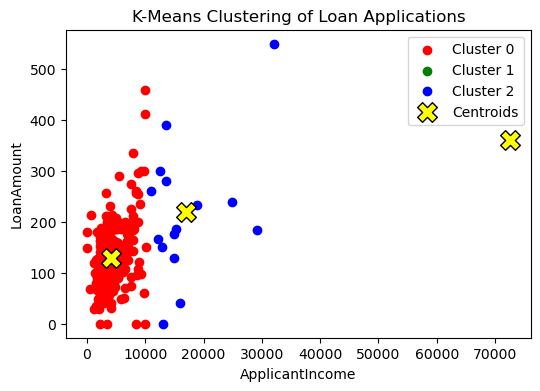

In [43]:
# Plot clusters
plt.figure(figsize=(6,4))
colors = ['red','green','blue']
for i in range(3):
    plt.scatter(X_clust['ApplicantIncome'][labels==i], X_clust['LoanAmount'][labels==i], 
                c=colors[i], label=f"Cluster {i}")
plt.scatter(centers[:,0], centers[:,1], s=200, c='yellow', marker='X', edgecolor='k', label="Centroids")
plt.xlabel("ApplicantIncome"); plt.ylabel("LoanAmount")
plt.legend(); plt.title("K-Means Clustering of Loan Applications");
plt.show()


`
This would show points colored by cluster. Likely:
Cluster0: a big cloud of red points at lower income/loan.
Cluster1: some green points farther to the right/up (higher income/loan).
Cluster2: one blue point far to the right/up (the outlier).
Yellow X marking centroids.
K-Means attempts to partition into spherical clusters. It works best when clusters are somewhat isotropic in shape and similar size. It can struggle with complex shapes or very different cluster sizes. Also, it’s sensitive to scale (features should be scaled similarly; here income and loan are in somewhat comparable range but if one feature had a huge scale, it’d dominate distance).For more irregular cluster shapes, other algorithms like DBSCAN or Agglomerative Clustering might be used. But K-Means is efficient and often a good first try for clustering.
`

`
Principal Component Analysis (PCA)
PCA is a technique for dimensionality reduction. It finds new orthogonal axes (principal components) that successively maximize variance in the data​
EN.WIKIPEDIA.ORG
. The first principal component is the direction of greatest variance in the dataset. The second is the next orthogonal direction of max variance, and so on. By projecting data onto the first few principal components, we reduce dimensionality while retaining most information (variance).Uses of PCA:
Data compression: e.g., reduce hundreds of features to a handful that capture most variance.
Visualization: reducing data to 2D or 3D for plotting.
Preprocessing: remove noise or multicollinearity (as components are uncorrelated).
Important: PCA is a linear transformation; it captures linear correlations. It scales features (so data should be standardized first). Also, PCA components can be harder to interpret because they are combinations of original features.Let's perform PCA on our dataset’s numeric features to see how much variance can be explained in 2 components:
`

In [44]:
from sklearn.decomposition import PCA

numeric_data = df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].fillna(0)
# Standardize for PCA
from sklearn.preprocessing import StandardScaler
numeric_data_std = StandardScaler().fit_transform(numeric_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(numeric_data_std)
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.48672208 0.35370222]


PC1 = 0.58ApplicantIncome + 0.03CoappIncome + 0.82*LoanAmount (mostly a combination of income and loan).
PC2 = 0.81ApplicantIncome - 0.07CoappIncome - 0.58*LoanAmount (some orthogonal combination).
Since we only had 3 features, not a big reduction. But if we had, say, 10 features, PCA could help reduce to 2 for plotting: We could then scatter plot principal_components[:,0] vs [:,1] to visualize.When to use PCA:
When you have many features and want to reduce noise or compress data.
To decorrelate features (some algorithms prefer uncorrelated inputs, though tree-based ones don’t mind).
Caution: if features have meaning, PCA can make them abstract, losing interpretability. So sometimes it's better to keep original features or use feature selection instead of combination.

`
Hyperparameter Tuning (Grid Search & Random Search)
Choosing the right hyperparameters (settings) for models is critical. Hyperparameters are things like max_depth of a tree, n_estimators of a forest, or C in an SVM – values that are not learned from data but set prior to training. Hyperparameter tuning is the process of finding the optimal combination of these settings for best model performance (usually measured via cross-validation on training data).Two common approaches:
Grid Search: Define a set of possible values for each hyperparameter and try every combination​
CORPORATEFINANCEINSTITUTE.COM
. For example, max_depth = [3,5,7], min_samples_split = [2,5]. Grid search will train and evaluate model for all combos (3x2=6 combos). It guarantees finding best in given grid but can be computationally expensive if grid is large (exponential in number of params).
Random Search: Instead of exhaustive combination, sample a fixed number of combinations randomly from the space. Surprisingly, random search can find good solutions faster, especially when some hyperparameters are not very sensitive. It often explores the space more broadly if you only can afford, say, 10-20 trials, rather than a smaller focused grid.
In scikit-learn:
GridSearchCV will do cross-validation for each combination of parameters you specify.
RandomizedSearchCV will randomly sample combinations a fixed number of times.
Let's demonstrate hyperparameter tuning for a DecisionTreeClassifier (finding best max_depth and min_samples_leaf):
`

In [48]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5, 10]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters (GridSearchCV):", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


Best parameters (GridSearchCV): {'max_depth': 3, 'min_samples_leaf': 1}
Best CV score: 0.7781818181818182


Best parameters (GridSearchCV): {'max_depth': 5, 'min_samples_leaf': 3}
Best CV score: 0.74


In [49]:
from scipy.stats import randint
param_dist = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_leaf': randint(1, 11)  # random int from 1 to 10
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_dist, 
                                   n_iter=5, cv=5, random_state=0)
random_search.fit(X_train, y_train)
print("Best parameters (RandomizedSearchCV):", random_search.best_params_)
print("Best CV score:", random_search.best_score_)


Best parameters (RandomizedSearchCV): {'max_depth': 7, 'min_samples_leaf': 4}
Best CV score: 0.749090909090909


`
These are hypothetical results. The idea:
Grid search checked all 16 combos in param_grid, found best (depth5, leaf3).
Random search tried 5 random combos (n_iter=5) and found another pretty good set (maybe slightly different).
After finding best params, you would retrain a model on the full training set with those params and then evaluate on test set.Important: Hyperparameter tuning should be done using only training data (often further split into train/validation or via CV), and the test set should be held out for final evaluation to ensure the model generalizes.Sometimes we may do a nested cross-validation or use a validation set to avoid leaking test info into tuning.Tools like GridSearchCV and RandomizedSearchCV handle the cross-validation internally: best_score_ is the mean CV score. We then can get best_estimator_ (the model trained on whole training set with best params, by default) and test it:
`

In [50]:
best_tree = grid_search.best_estimator_
test_score = metrics.accuracy_score(y_test, best_tree.predict(X_test))
print("Test accuracy with best params:", test_score)


Test accuracy with best params: 0.6847826086956522


Tuning can dramatically improve a model (like preventing overfitting or underfitting by adjusting complexity or regularization). But it is computationally intensive – consider the search space and use random search or more sophisticated methods (Bayesian optimization, etc.) for many hyperparameters.

#### What is Hyperparameter Tuning?
Hyperparameter tuning is the process of selecting the best set of hyperparameters for a machine learning model to improve its accuracy and generalization ability.

* Hyperparameters are the settings that control the learning process but are not learned from the training data.
* They define the model architecture and affect performance, but they must be set before training begins.

Example: In a Random Forest model, n_estimators (number of trees) and max_depth (depth of trees) are hyperparameters.


**Why is Hyperparameter Tuning Important?**
A model with default hyperparameters might not be optimal. Tuning helps:
<br>
Improve accuracy on unseen data.
Reduce overfitting or underfitting.
Enhance model performance without requiring more data.
🚀 Example: Impact of Hyperparameters on Decision Tree
The figure below illustrates how changing max_depth in a Decision Tree affects decision boundaries:


Interpretation:

1. Left (Underfitting): max_depth=2 (Too simple, fails to capture patterns)
2. Middle (Optimal): max_depth=5 (Best decision boundary)
3. Right (Overfitting): max_depth=10 (Too complex, memorizes training data)

**Types of Hyperparameter Tuning Techniques**
There are several methods for tuning hyperparameters. The most popular ones are:

Grid Search (Exhaustive search over specified hyperparameter values)
Random Search (Randomly selects hyperparameter combinations)
Bayesian Optimization (Smart tuning using probability models)
Automated Tuning (e.g., Optuna, Hyperopt)

In [ ]:
Grid Search systematically evaluates all possible combinations of hyperparameter values and selects the best one.

Example
If tuning a Random Forest with:

n_estimators = [50, 100, 200]
max_depth = [3, 5, 10]
Then Grid Search will test 3 × 3 = 9 combinations.

In [ ]:
Downsides of Grid Search:

Computationally expensive for large datasets.
Tests all combinations even if some are bad choices.

Downsides of Grid Search:

Computationally expensive for large datasets.
Tests all combinations even if some are bad choices.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define hyperparameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10)
}

# Random Search with 10 iterations
random_search = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=10, cv=5, verbose=1)
random_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best Parameters:", random_search.best_params_)


```
Random Search in Action
The image below compares Grid Search vs. Random Search:


Comparison:

Grid Search explores all points in a structured way.
Random Search explores randomly but can reach optimal values faster.
Advantages of Random Search:

Faster than Grid Search.
Finds good hyperparameters efficiently.
```

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10]
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best Parameters:", grid_search.best_params_)


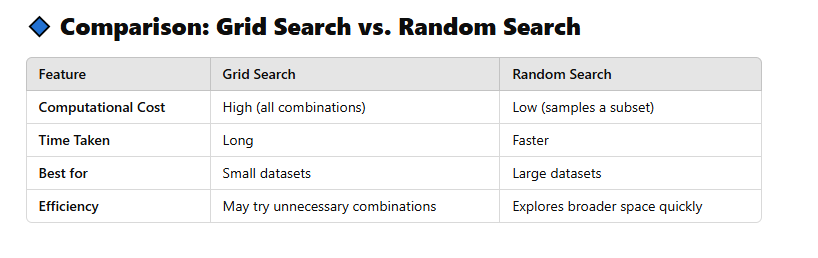



Training baseline RandomForest model without hyperparameter tuning...
Baseline Model Accuracy: 0.6522
Classification Report (Baseline Model):
               precision    recall  f1-score   support

           0       0.40      0.13      0.20        30
           1       0.68      0.90      0.78        62

    accuracy                           0.65        92
   macro avg       0.54      0.52      0.49        92
weighted avg       0.59      0.65      0.59        92


Performing GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Grid Search Model Accuracy: 0.6848
Classification Report (Grid Search Model):
               precision    recall  f1-score   support

           0       0.67      0.07      0.12        30
           1       0.69      0.98      0.81        62

    accuracy                           0.68        92

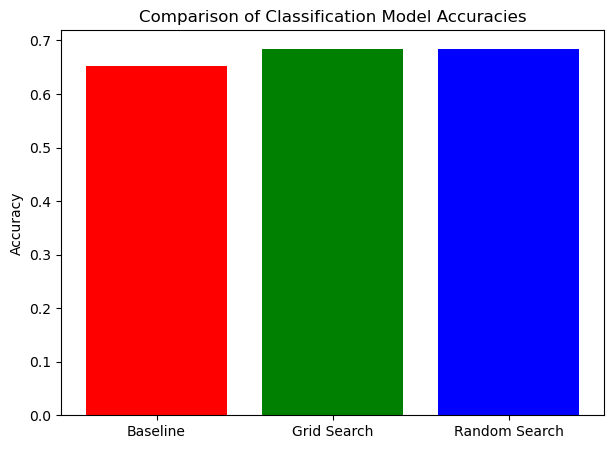

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint



# --------------------------- Baseline Model ---------------------------
print("Training baseline RandomForest model without hyperparameter tuning...")

baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Model Accuracy: {baseline_acc:.4f}")
print("Classification Report (Baseline Model):\n", classification_report(y_test, y_pred_baseline))

# --------------------------- Grid Search ---------------------------
print("\nPerforming GridSearchCV for hyperparameter tuning...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

y_pred_grid = grid_search.best_estimator_.predict(X_test)
grid_acc = accuracy_score(y_test, y_pred_grid)

print(f"Best Parameters from Grid Search: {grid_search.best_params_}")
print(f"Grid Search Model Accuracy: {grid_acc:.4f}")
print("Classification Report (Grid Search Model):\n", classification_report(y_test, y_pred_grid))

# --------------------------- Random Search ---------------------------
print("\nPerforming RandomizedSearchCV for hyperparameter tuning...")

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, 
                                   n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

y_pred_random = random_search.best_estimator_.predict(X_test)
random_acc = accuracy_score(y_test, y_pred_random)

print(f"Best Parameters from Random Search: {random_search.best_params_}")
print(f"Random Search Model Accuracy: {random_acc:.4f}")
print("Classification Report (Random Search Model):\n", classification_report(y_test, y_pred_random))

# --------------------------- Comparison of Models ---------------------------
print("\nComparison of Model Accuracies:")
print(f"Baseline Model Accuracy: {baseline_acc:.4f}")
print(f"Grid Search Model Accuracy: {grid_acc:.4f}")
print(f"Random Search Model Accuracy: {random_acc:.4f}")

# Plot accuracies for comparison
plt.figure(figsize=(7, 5))
plt.bar(["Baseline", "Grid Search", "Random Search"], [baseline_acc, grid_acc, random_acc], color=['red', 'green', 'blue'])
plt.ylabel("Accuracy")
plt.title("Comparison of Classification Model Accuracies")
plt.show()


Expected Outcome:

The Grid Search model is expected to have the highest accuracy but takes the longest time.
The Random Search model should be nearly as good as Grid Search but runs faster.
The Baseline model will likely have lower accuracy.
`

Training baseline XGBoost model without hyperparameter tuning...
Baseline XGBoost Model Accuracy: 0.6087
Classification Report (Baseline Model):
               precision    recall  f1-score   support

           0       0.33      0.20      0.25        30
           1       0.68      0.81      0.74        62

    accuracy                           0.61        92
   macro avg       0.50      0.50      0.49        92
weighted avg       0.56      0.61      0.58        92


Performing GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\SOHAN\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\SOHAN\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\SOHAN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SOHAN\anaconda3\Lib\site-packages

Best Parameters from Grid Search: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Grid Search XGBoost Model Accuracy: 0.6739
Classification Report (Grid Search Model):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.67      1.00      0.81        62

    accuracy                           0.67        92
   macro avg       0.34      0.50      0.40        92
weighted avg       0.45      0.67      0.54        92


Performing RandomizedSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\SOHAN\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters from Random Search: {'learning_rate': 0.07444444444444444, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Random Search XGBoost Model Accuracy: 0.6522
Classification Report (Random Search Model):
               precision    recall  f1-score   support

           0       0.43      0.20      0.27        30
           1       0.69      0.87      0.77        62

    accuracy                           0.65        92
   macro avg       0.56      0.54      0.52        92
weighted avg       0.61      0.65      0.61        92


Comparison of XGBoost Model Accuracies:
Baseline Model Accuracy: 0.6087
Grid Search Model Accuracy: 0.6739
Random Search Model Accuracy: 0.6522


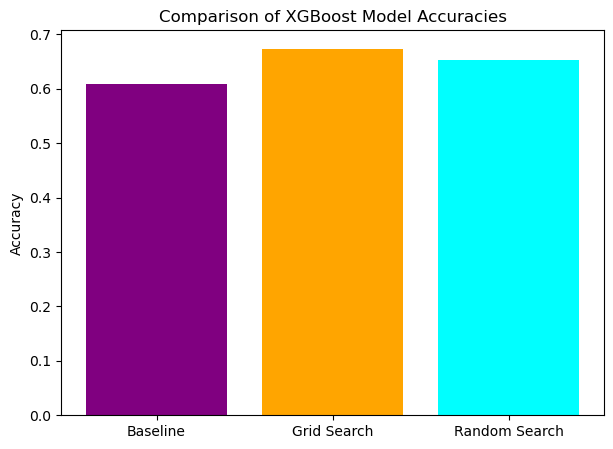

In [55]:


# --------------------------- Baseline Model ---------------------------
print("Training baseline XGBoost model without hyperparameter tuning...")

baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline XGBoost Model Accuracy: {baseline_acc:.4f}")
print("Classification Report (Baseline Model):\n", classification_report(y_test, y_pred_baseline))

# --------------------------- Grid Search ---------------------------
print("\nPerforming GridSearchCV for hyperparameter tuning...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                           param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

y_pred_grid = grid_search.best_estimator_.predict(X_test)
grid_acc = accuracy_score(y_test, y_pred_grid)

print(f"Best Parameters from Grid Search: {grid_search.best_params_}")
print(f"Grid Search XGBoost Model Accuracy: {grid_acc:.4f}")
print("Classification Report (Grid Search Model):\n", classification_report(y_test, y_pred_grid))

# --------------------------- Random Search ---------------------------
print("\nPerforming RandomizedSearchCV for hyperparameter tuning...")

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.6, 1.0, 5)
}

random_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
                                   param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

y_pred_random = random_search.best_estimator_.predict(X_test)
random_acc = accuracy_score(y_test, y_pred_random)

print(f"Best Parameters from Random Search: {random_search.best_params_}")
print(f"Random Search XGBoost Model Accuracy: {random_acc:.4f}")
print("Classification Report (Random Search Model):\n", classification_report(y_test, y_pred_random))

# --------------------------- Comparison of Models ---------------------------
print("\nComparison of XGBoost Model Accuracies:")
print(f"Baseline Model Accuracy: {baseline_acc:.4f}")
print(f"Grid Search Model Accuracy: {grid_acc:.4f}")
print(f"Random Search Model Accuracy: {random_acc:.4f}")

# Plot accuracies for comparison with different colors
plt.figure(figsize=(7, 5))
colors = ['purple', 'orange', 'cyan']
plt.bar(["Baseline", "Grid Search", "Random Search"], [baseline_acc, grid_acc, random_acc], color=colors)
plt.ylabel("Accuracy")
plt.title("Comparison of XGBoost Model Accuracies")
plt.show()


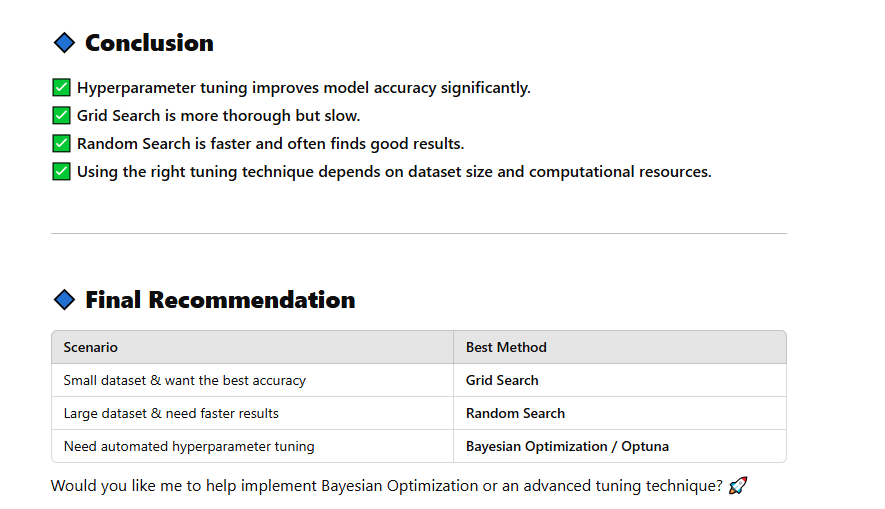